# Importation des librairies

Importe toutes les bibliothèques nécessaires :    
- numpy, pandas pour la gestion des données,
- matplotlib.pyplot pour les graphiques,
- sklearn.model_selection et sklearn.metrics pour séparer les données et évaluer les performances,
- RandomForestClassifier pour entraîner le modèle de classification,
- shap pour interpréter les prédictions du modèle.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import shap

# Chargement et pré-traitement des données

Je charge le fichier "creditcard_2023.csv" dans un DataFrame df.

Je sépare les données :
   - X contient toutes les colonnes sauf "Class" et "id", ce sont les variables explicatives.
   - y contient la colonne "Class", c’est la variable cible (fraude ou non).

Je divise les données en trois ensembles avec train_test_split :
   - X_train / y_train : pour entraîner le modèle (70 % des données),
   - X_valid / y_valid : pour valider le modèle (15 %),
   - X_test / y_test : pour le test final (15 %).

J’utilise la stratification pour conserver les proportions de fraudes/non-fraudes dans chaque sous-ensemble.

In [ ]:
df = pd.read_csv("creditcard_2023.csv")

X = df.drop(["Class", "id"], axis=1)
y = df["Class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Création du modèle de base et cacul de l'AUC-ROC

Je construis un modèle RandomForestClassifier avec des hyperparamètres fixés manuellement :
   - n_estimators=100 : je construis 100 arbres dans la forêt,
   - max_depth=5 : chaque arbre a une profondeur maximale de 5, ce qui limite le sur-apprentissage,
   - max_features='sqrt' : à chaque division, seule √(n_features) variables sont testées,
   - min_samples_split=10 : au moins 10 échantillons sont nécessaires pour diviser un nœud,
   - min_samples_leaf=4 : chaque feuille doit contenir au moins 4 échantillons,
   - bootstrap=True : j’utilise l’échantillonnage avec remise pour construire les arbres,
   - random_state=42 : pour la reproductibilité.

J’entraîne ce modèle avec les données X_train et y_train.

Je prédis ensuite la probabilité que chaque transaction soit frauduleuse (y_proba).

In [57]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=True,
    random_state=42
)

model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]

# Calcul de l'AUC-ROC, de la précision, du rappel et du F1-score

Je calcule le score AUC-ROC avec roc_auc_score, une métrique globale très utile pour évaluer un classifieur déséquilibré (comme ici, avec très peu de fraudes).

Je trace la courbe ROC grâce à roc_curve et matplotlib :
   - Elle permet de visualiser la performance du modèle en montrant le compromis entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR).
   - Une courbe qui monte rapidement vers le coin supérieur gauche indique un bon modèle.
   - Je superpose la diagonale grise (modèle aléatoire) pour comparaison.

À ce stade, j'évalue plus en détail les performances de mon modèle Random Forest au-delà de l’AUC-ROC.
   - Je transforme les probabilités prédites (y_proba) en classes binaires (y_pred) en appliquant un seuil de 0.5.
   - Je calcule la matrice de confusion pour visualiser la répartition des prédictions correctes et erronées entre fraudes et non-fraudes.
   - J'affiche un rapport de classification, qui inclut la précision, le rappel et le F1-score pour chaque classe (0 = transaction normale, 1 = fraude).
   - Je mesure individuellement la précision, le rappel et le F1-score pour la classe "fraude", afin d’avoir une meilleure compréhension de la capacité du modèle à détecter les cas critiques.

Ces indicateurs sont particulièrement utiles dans un contexte de classes déséquilibrées, comme ici, car ils permettent de mieux comprendre les performances du modèle sur la classe minoritaire (les fraudes).

In [ ]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC sur test : {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()

y_pred = (y_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)

print("\nRapport de classification :\n", classification_report(y_test, y_pred, digits=4))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Précision : {precision:.4f}")
print(f"Rappel    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

# SHAP

À cette étape, j'interprète les prédictions de mon modèle Random Forest grâce à SHAP (SHapley Additive exPlanations), une méthode d’explicabilité basée sur la théorie des jeux.
   - Je crée un explainer à partir de la méthode shap.Explainer, en utilisant la prédiction du modèle et le jeu d'entraînement comme référence.
   - Je calcule les valeurs SHAP sur les instances de test, ce qui me permet de savoir dans quelle mesure chaque feature a contribué à chaque prédiction.
   - J’affiche un graphe summary_plot pour visualiser les variables les plus influentes globalement sur les prédictions.
   - Je réalise ensuite une analyse locale, en affichant un waterfall plot pour 5 instances du jeu de test. Ce graphe me montre comment chaque feature a poussé la prédiction vers le haut ou vers le bas, à partir d’une valeur de base (baseline).

Cette partie me permet donc d’expliquer concrètement les décisions du modèle, ce qui est crucial dans le domaine bancaire pour justifier les alertes de fraude.

PermutationExplainer explainer: 85296it [2:23:37,  9.89it/s]                             


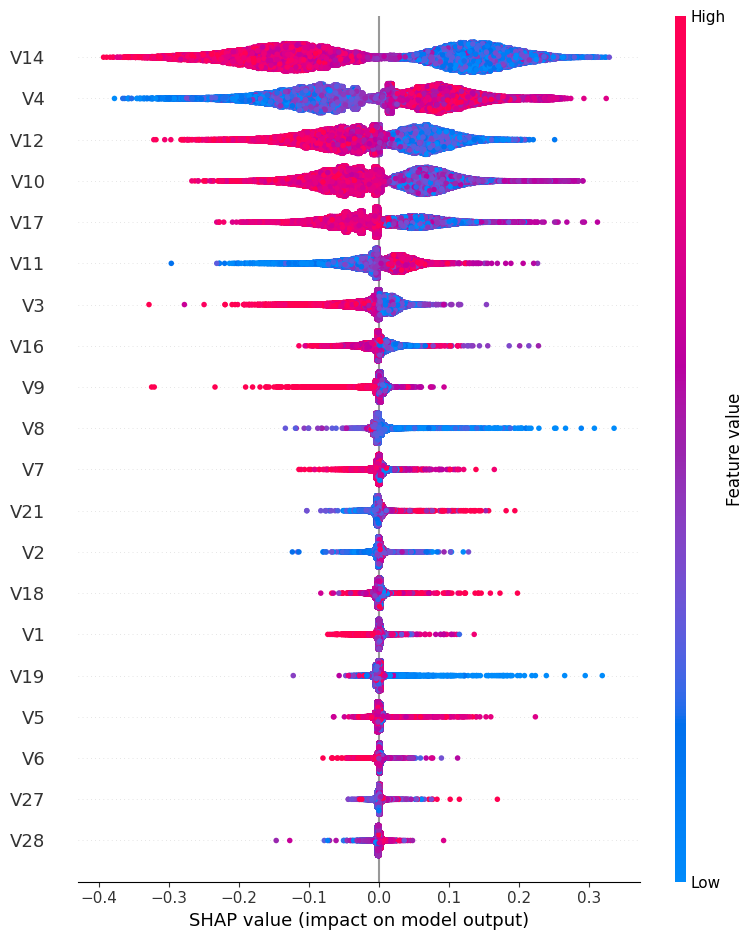


===== Instance 0 =====


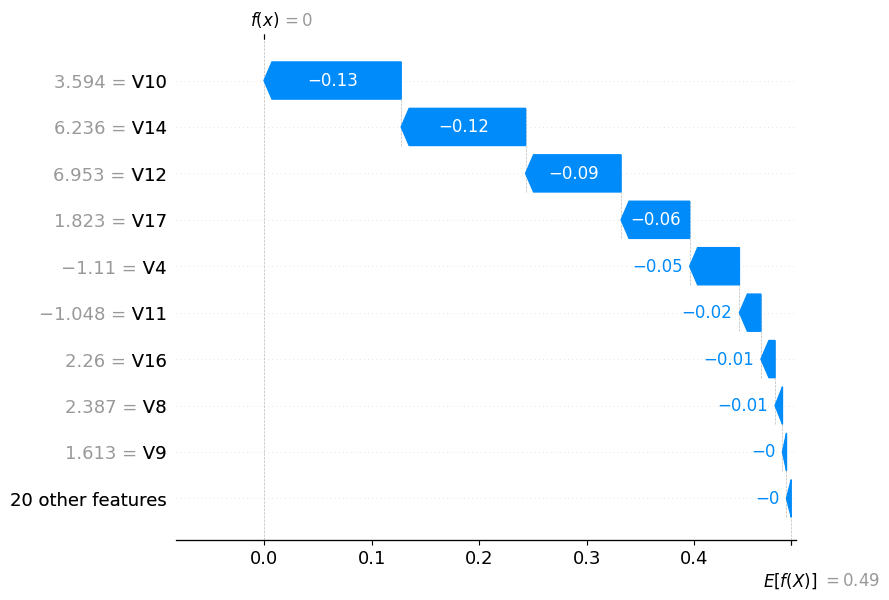


===== Instance 1 =====


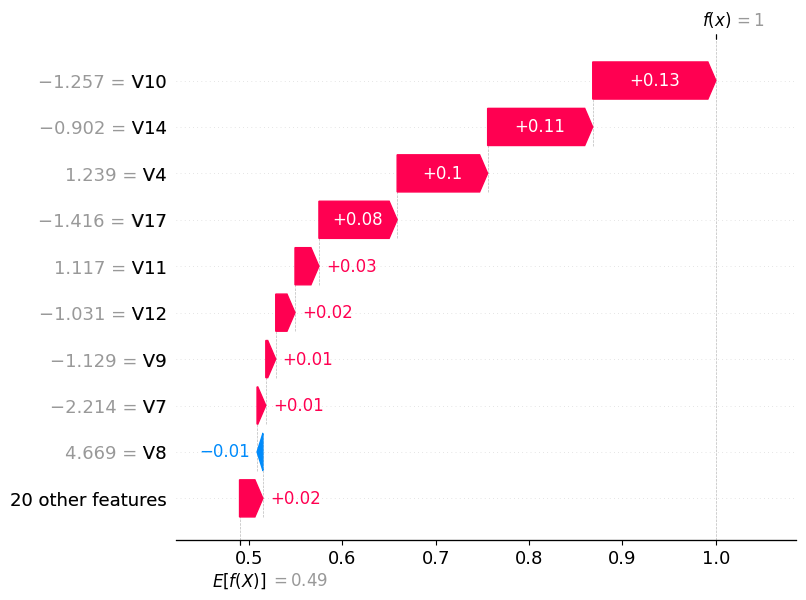


===== Instance 2 =====


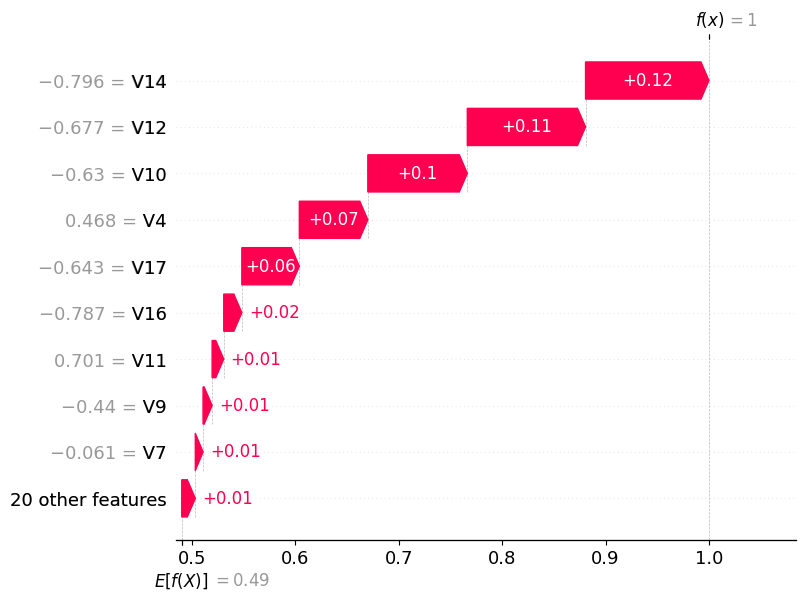


===== Instance 3 =====


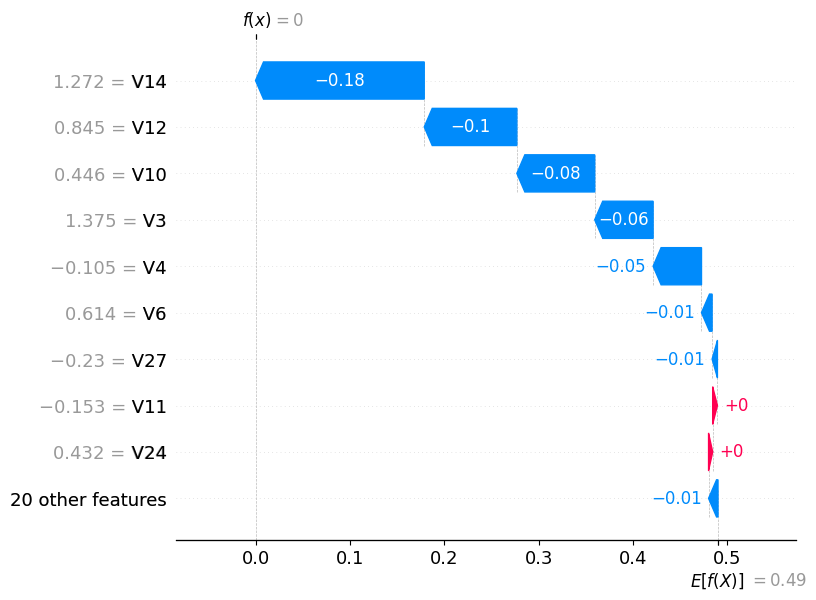


===== Instance 4 =====


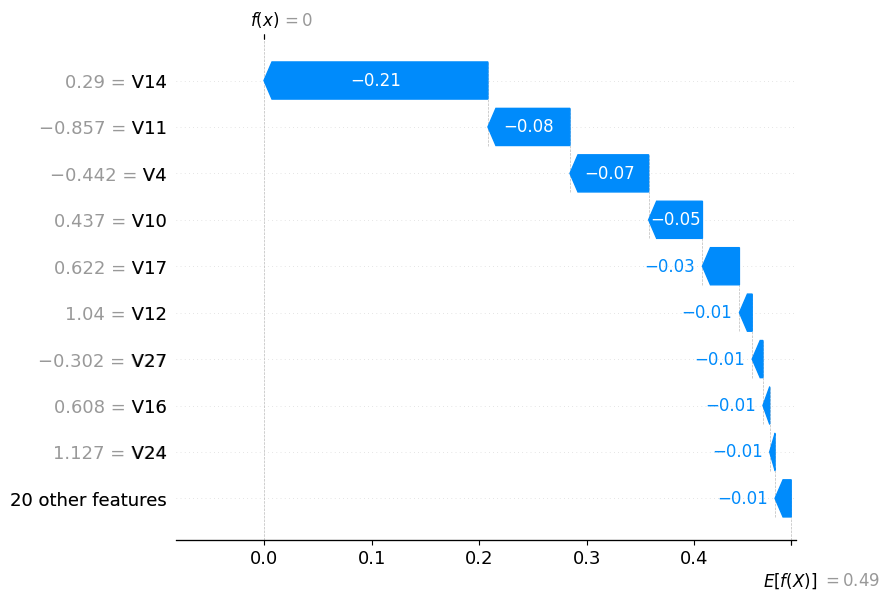

In [55]:
shap_explainer = shap.Explainer(model.predict, X_train)
shap_values = shap_explainer(X_test)

shap.summary_plot(shap_values, X_test)

for i in range(5):
    print(f"\n===== Instance {i} =====")
    shap.plots.waterfall(shap_values[i])

# LIME

In [56]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Classe 0', 'Classe 1'],
    mode='classification'
)

n = 5
for i in range(n):
    print(f"\n===== Instance {i} =====")

    exp = explainer.explain_instance(
        data_row=X_valid.iloc[i],
        predict_fn=model.predict_proba,
        num_features=10
    )
    exp.show_in_notebook(show_table=True)


===== Instance 0 =====


c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 


===== Instance 1 =====


c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 


===== Instance 2 =====


c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 


===== Instance 3 =====


c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 


===== Instance 4 =====


c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Apps\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 